# Library

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from scipy.stats import norm, kstest
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
tickers = ['BABA', 'QCOM', 'TSLA']

In [3]:
stocks_df = yf.download(tickers, start="2023-12-01", end="2024-11-30")['Close']

stocks_df.index = pd.to_datetime(stocks_df.index)

# Tampilkan DataFrame yang telah digabung
stocks_df

[*********************100%***********************]  3 of 3 completed


Ticker,BABA,QCOM,TSLA
Date,,,
2023-12-01,73.989998,129.669998,238.830002
2023-12-04,73.029999,129.949997,235.580002
2023-12-05,72.379997,130.750000,238.720001
2023-12-06,71.489998,129.960007,239.369995
2023-12-07,72.330002,132.940002,242.639999
...,...,...,...
2024-11-22,83.129997,156.789993,352.559998
2024-11-25,85.580002,158.820007,338.589996
2024-11-26,85.180000,156.929993,338.230011


# Log Return

In [4]:
# log_returns =  np.log(stocks_df / stocks_df.shift(1)).dropna()
log_returns =  np.log(stocks_df / stocks_df.shift(1)).dropna()
log_returns

Ticker,BABA,QCOM,TSLA
Date,,,
2023-12-04,-0.013060,0.002157,-0.013701
2023-12-05,-0.008940,0.006137,0.013241
2023-12-06,-0.012372,-0.006060,0.002719
2023-12-07,0.011681,0.022671,0.013568
2023-12-08,-0.002630,0.000226,0.004933
...,...,...,...
2024-11-22,-0.029046,0.008519,0.037335
2024-11-25,0.029046,0.012864,-0.040431
2024-11-26,-0.004685,-0.011972,-0.001064


In [5]:
log_returns.index = pd.to_datetime(log_returns.index)

In [6]:
# Gabungkan log returns dengan stocks_df_cut
combined_df = pd.concat([stocks_df, log_returns], axis=1)

# Ubah nama kolom agar lebih jelas
combined_df.columns = [f'{col}_Close' if i < len(stocks_df.columns) else f'{col}_LogReturn' 
                       for i, col in enumerate(stocks_df.columns.append(log_returns.columns))]

# Tampilkan DataFrame yang sudah digabung
combined_df

,BABA_Close,QCOM_Close,TSLA_Close,BABA_LogReturn,QCOM_LogReturn,TSLA_LogReturn
Date,,,,,,
2023-12-01,73.989998,129.669998,238.830002,NaN,NaN,NaN
2023-12-04,73.029999,129.949997,235.580002,-0.013060,0.002157,-0.013701
2023-12-05,72.379997,130.750000,238.720001,-0.008940,0.006137,0.013241
2023-12-06,71.489998,129.960007,239.369995,-0.012372,-0.006060,0.002719
2023-12-07,72.330002,132.940002,242.639999,0.011681,0.022671,0.013568
...,...,...,...,...,...,...
2024-11-22,83.129997,156.789993,352.559998,-0.029046,0.008519,0.037335
2024-11-25,85.580002,158.820007,338.589996,0.029046,0.012864,-0.040431
2024-11-26,85.180000,156.929993,338.230011,-0.004685,-0.011972,-0.001064


In [7]:
combined_df.describe()

,BABA_Close,QCOM_Close,TSLA_Close,BABA_LogReturn,QCOM_LogReturn,TSLA_LogReturn
count,251.000000,251.000000,251.000000,250.000000,250.000000,250.000000
mean,80.671394,169.580319,216.424462,0.000665,0.000804,0.001473
std,10.504052,20.741228,43.488166,0.023200,0.024137,0.038126
min,68.050003,129.669998,142.050003,-0.069041,-0.098354,-0.131643
25%,73.535000,156.859993,180.000000,-0.012904,-0.011663,-0.019282
50%,76.980003,168.100006,210.660004,0.000489,0.002187,0.000713
75%,83.700001,175.645004,241.845001,0.013744,0.013977,0.019295
max,117.519997,227.089996,352.559998,0.095919,0.092975,0.198187


In [8]:
combined_df.to_csv('stocks_and_log_returns.csv')

In [9]:
# from bokeh.layouts import gridplot
# from bokeh.models import ColumnDataSource, HoverTool
# from bokeh.plotting import figure, show, output_file

# # Prepare the output file
# output_file("stock_prices_log_returns.html")

# # Create a list to hold all the plots
# plots = []

# # Define the companies and their respective colors
# companies = {
#     'BABA': 'blue',
#     'QCOM': 'orange',
#     'TSLA': 'green',
# }

# # Iterate over each company to create plots
# for company, color in companies.items():
#     # Create a ColumnDataSource
#     source = ColumnDataSource(data={
#         'date': combined_df.index,
#         'close': combined_df[f'{company}_Close'],
#         'log_return': combined_df[f'{company}_LogReturn']
#     })

#     # Create the closing price plot
#     p_close = figure(x_axis_type='datetime', title=f'{company} Closing Price')
#     p_close.line('date', 'close', source=source, color=color, legend_label=f'{company} Close')
#     p_close.add_tools(HoverTool(
#         tooltips=[
#             ('Date', '@date{%F}'),
#             ('Close', '@close{0.2f}')
#         ],
#         formatters={'@date': 'datetime'},
#         mode='vline'
#     ))
#     p_close.legend.location = 'top_left'
#     p_close.xaxis.axis_label = 'Date'
#     p_close.yaxis.axis_label = 'Price'
#     plots.append(p_close)

#     # Create the log return plot
#     p_log_return = figure(x_axis_type='datetime', title=f'{company} Log Return')
#     p_log_return.line('date', 'log_return', source=source, color=color, legend_label=f'{company} Log Return')
#     p_log_return.add_tools(HoverTool(
#         tooltips=[
#             ('Date', '@date{%F}'),
#             ('Log Return', '@log_return{0.4f}')
#         ],
#         formatters={'@date': 'datetime'},
#         mode='vline'
#     ))
#     p_log_return.legend.location = 'top_left'
#     p_log_return.xaxis.axis_label = 'Date'
#     p_log_return.yaxis.axis_label = 'Log Return'
#     plots.append(p_log_return)

# # Arrange plots in a 2x3 grid
# grid = gridplot([plots[:3], plots[3:]], sizing_mode='stretch_both')

# # Show the grid
# show(grid)


# Plot ACF & PACF

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def uji_acf_pacf(log_returns, tickers):
    
    for ticker in tickers:
        print(f"Uji ACF untuk {ticker}")
        
        # Plot ACF
        plt.figure(figsize=(10, 6))
        plot_acf(log_returns[ticker], lags=20)
        plt.title(f'ACF untuk {ticker}')
        plt.show()

        print(f"Uji PACF untuk {ticker}")
        
        # Plot PACF
        plt.figure(figsize=(10, 6))
        plot_pacf(log_returns[ticker], lags=20)
        plt.title(f'PACF untuk {ticker}')
        plt.show()

Uji ACF untuk BABA


<Figure size 1000x600 with 0 Axes>

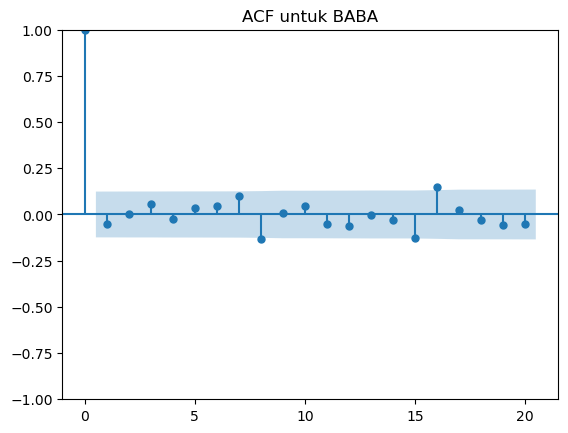

Uji PACF untuk BABA


<Figure size 1000x600 with 0 Axes>

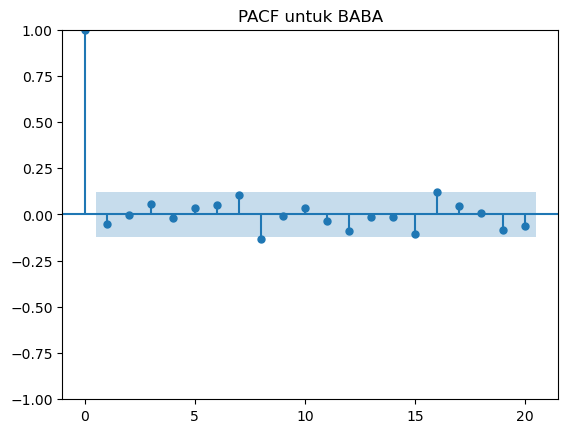

Uji ACF untuk QCOM


<Figure size 1000x600 with 0 Axes>

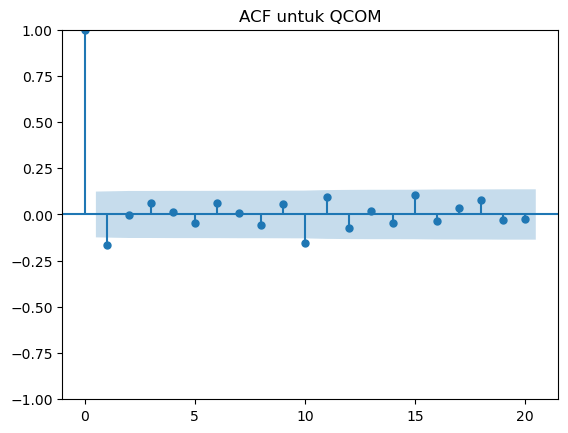

Uji PACF untuk QCOM


<Figure size 1000x600 with 0 Axes>

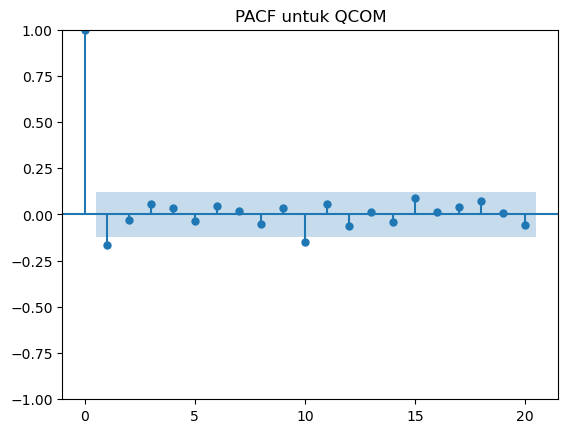

Uji ACF untuk TSLA


<Figure size 1000x600 with 0 Axes>

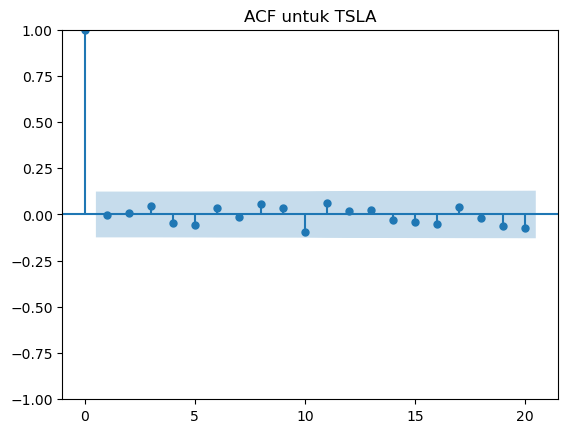

Uji PACF untuk TSLA


<Figure size 1000x600 with 0 Axes>

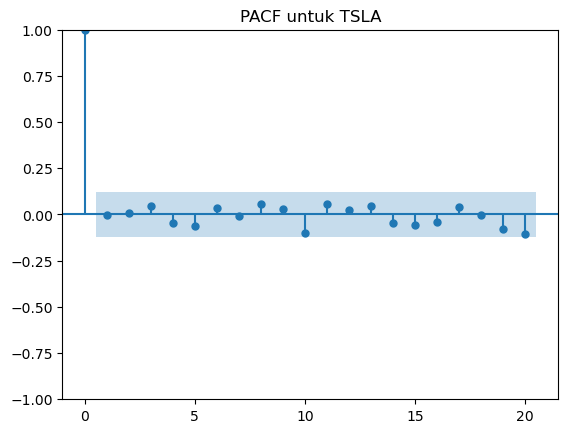

In [11]:
# Panggil fungsi uji ACF dan PACF
uji_acf_pacf(log_returns, tickers)

# Uji Normalitas Return: Kolmogorov-Smirnov

In [12]:
# Langkah 3: Uji Normalitas (Kolmogorov-Smirnov)
def kolmogorov_smirnov_test(data):
    # Uji Kolmogorov-Smirnov terhadap distribusi normal
    stat, p_value = kstest(data, 'norm', args=(data.mean(), data.std()))
    print(f"KS Test Statistic: {stat}, p-value: {p_value}")
    if p_value < 0.05:
        print("Data tidak berdistribusi normal")
    else:
        print("Data berdistribusi normal")
    print("")

# Uji normalitas untuk masing-masing saham
for ticker in tickers:
    print(f"Uji Normalitas untuk {ticker}")
    kolmogorov_smirnov_test(log_returns[ticker])


Uji Normalitas untuk BABA
KS Test Statistic: 0.05549351439258132, p-value: 0.4098001288130556
Data berdistribusi normal

Uji Normalitas untuk QCOM
KS Test Statistic: 0.06332566713304377, p-value: 0.2576147051493286
Data berdistribusi normal

Uji Normalitas untuk TSLA
KS Test Statistic: 0.0785303213361207, p-value: 0.08678202644806865
Data berdistribusi normal



# Uji Stastioneritas

In [13]:
# Fungsi untuk uji Augmented Dickey-Fuller (ADF) untuk stasioneritas
def uji_adf(time_series):
    # Menjalankan uji ADF
    result = adfuller(time_series)
    
    # Menampilkan hasil uji ADF
    print(f"Statistik ADF: {result[0]}")
    print(f"p-value: {result[1]}")
    
    # Menginterpretasikan hasil uji
    if result[1] < 0.05:
        print("Data stasioner: p-value < 0.05, hipotesis nol ditolak")
    else:
        print("Data tidak stasioner: p-value >= 0.05, hipotesis nol diterima")
    print("")

for ticker in tickers:
    uji_adf(log_returns[ticker])

Statistik ADF: -16.600785148294463
p-value: 1.7652875822781683e-29
Data stasioner: p-value < 0.05, hipotesis nol ditolak

Statistik ADF: -18.56528327576993
p-value: 2.085322483072653e-30
Data stasioner: p-value < 0.05, hipotesis nol ditolak

Statistik ADF: -15.742778521871593
p-value: 1.250067082894665e-28
Data stasioner: p-value < 0.05, hipotesis nol ditolak



# AR

In [14]:
P_AR = 1

In [15]:

# Fungsi untuk membangun dan menyesuaikan model AR
def ar_model(data, lags=1):
    # Membangun model AR dengan menggunakan lags tertentu (misalnya, p=1 untuk AR(1))
    model = AutoReg(data, lags=lags)
    model_fit = model.fit()
    print(model_fit.summary())  # Menampilkan ringkasan hasil model
    print("")
    return model_fit

residuals_df = pd.DataFrame()

# Modelkan AR untuk setiap ticker
for ticker in tickers:
    print("==============================================================================")
    print(f"=========================== Model AR untuk {ticker} ============================")
    print("==============================================================================")
    
    # Modelkan AR untuk data log returns masing-masing saham
    result = ar_model(log_returns[ticker], lags=P_AR)

    # Langkah berikutnya bisa dilakukan sesuai dengan analisis residual atau prediksi
    residuals = result.resid  # Mendapatkan residual dari model AR

    # Menambahkan residuals ke dalam DataFrame
    residuals_df[ticker] = residuals

    print(f"Uji Normalitas untuk Residu {ticker}")
    kolmogorov_smirnov_test(residuals)

    arch_test = het_arch(residuals)

    print(f"Uji heteroskedastisitas untuk Residu {ticker}")
    print(f"ARCH LM Test p-value: {arch_test[1]}\n")

    # Jika p-value < 0.05, maka ada bukti adanya heteroskedastisitas pada residuals
    if arch_test[1] < 0.05:
        print("Terdapat heteroskedastisitas pada residuals.")
    else:
        print("Tidak terdapat heteroskedastisitas pada residuals.")
    print("\n")

=========================== Model AR untuk BABA ============================
                            AutoReg Model Results                             
Dep. Variable:                   BABA   No. Observations:                  250
Model:                     AutoReg(1)   Log Likelihood                 584.365
Method:               Conditional MLE   S.D. of innovations              0.023
Date:                Sat, 07 Dec 2024   AIC                          -1162.729
Time:                        19:58:54   BIC                          -1152.177
Sample:                             1   HQIC                         -1158.482
                                  250                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.514      0.607      -0.002       0.004
BABA.L1       -0.0543      0.063     -0.858      0.391

In [16]:
# Initialize an empty list to store the results
results = []

# Function to perform diagnostic tests on residuals
def diagnostic_tests(residuals):
    # Normality Tests
    ks_stat, ks_p_value = kstest((residuals - residuals.mean()) / residuals.std(), 'norm')
    
    # Autocorrelation Test (Ljung-Box)
    lb_stat = acorr_ljungbox(residuals, lags=[10], return_df=True)["lb_stat"].values[0]
    lb_p_value= acorr_ljungbox(residuals, lags=[10], return_df=True)["lb_pvalue"].values[0]

    # Heteroskedasticity Test (ARCH LM Test)
    arch_stat, arch_p_value, _, _ = het_arch(residuals)
    
    return ks_stat, ks_p_value, lb_stat, lb_p_value, arch_stat, arch_p_value

# Iterate over each ticker to fit GARCH model and perform tests
for ticker in tickers:
    # Fit ARCH(1) model
    model_fit = ar_model(log_returns[ticker], lags=P_AR)
    
    # Obtain residuals
    residuals = model_fit.resid

    # Get parameter p-values dynamically
    pvalues = model_fit.pvalues
    param_pvalues = {f'{param} p-value': pval
                          for param, pval in pvalues.items()}
    param_significance = {f'{param} significance': ('Significant' if pval < 0.05 else 'Not Significant') 
                          for param, pval in pvalues.items()}
    
    # print(model_fit)
    # print(model_fit.params)
    # print(model_fit.pvalues)
    
    # Perform diagnostic tests
    ks_stat, ks_p_value, lb_stat, lb_p_value, arch_stat, arch_p_value = diagnostic_tests(residuals)
    
    # Append results to the list
    results.append({
        'Ticker': ticker,
        'KS Test Statistic': ks_stat,
        'KS p-value': ks_p_value,
        'Ljung-Box Test Statistic': lb_stat,
        'Ljung-Box p-value': lb_p_value,
        'ARCH LM Test Statistic': arch_stat,
        'ARCH LM p-value': arch_p_value,
        # **param_pvalues,
        # **param_significance
        
    })

# Convert results list to DataFrame
results_ar_df = pd.DataFrame(results)

# Display the summary DataFrame
results_ar_df


                            AutoReg Model Results                             
Dep. Variable:                   BABA   No. Observations:                  250
Model:                     AutoReg(1)   Log Likelihood                 584.365
Method:               Conditional MLE   S.D. of innovations              0.023
Date:                Sat, 07 Dec 2024   AIC                          -1162.729
Time:                        19:58:54   BIC                          -1152.177
Sample:                             1   HQIC                         -1158.482
                                  250                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.514      0.607      -0.002       0.004
BABA.L1       -0.0543      0.063     -0.858      0.391      -0.178       0.070
                                    Roots           

,Ticker,KS Test Statistic,KS p-value,Ljung-Box Test Statistic,Ljung-Box p-value,ARCH LM Test Statistic,ARCH LM p-value
0,BABA,0.057584,0.366928,9.289367,0.504880,23.359383,0.009495
1,QCOM,0.066476,0.211557,8.246334,0.604789,21.250147,0.019415
2,TSLA,0.076948,0.099435,5.996811,0.815531,23.082876,0.010445


In [17]:
# Significance level
alpha = 0.05

# Function to determine check or cross mark
def check_mark(p_value):
    return '✓' if p_value > alpha else '✗'

# Apply function to each p-value column to create new indicator columns
results_ar_df['Normal'] = results_ar_df['KS p-value'].apply(check_mark)
results_ar_df['Independent'] = results_ar_df['Ljung-Box p-value'].apply(check_mark)

# Untuk kolom Homoskedastic, membalikkan logika tanda
results_ar_df['Heteroskedastisitas'] = results_ar_df['ARCH LM p-value'].apply(lambda p: '✗' if p > alpha else '✓')
results_ar_df

,Ticker,KS Test Statistic,KS p-value,Ljung-Box Test Statistic,Ljung-Box p-value,ARCH LM Test Statistic,ARCH LM p-value,Normal,Independent,Heteroskedastisitas
0,BABA,0.057584,0.366928,9.289367,0.504880,23.359383,0.009495,✓,✓,✓
1,QCOM,0.066476,0.211557,8.246334,0.604789,21.250147,0.019415,✓,✓,✓
2,TSLA,0.076948,0.099435,5.996811,0.815531,23.082876,0.010445,✓,✓,✓


# ARCH

In [31]:
P_ARCH = 1

In [32]:
# Langkah 4: Model ARCH/GARCH
# Memodelkan ARCH (GARCH) untuk masing-masing saham
def arch_garch_model(data, p=1):
    model = arch_model(data, vol='ARCH', p=p, rescale=False)
    model_fit = model.fit(disp="off")
    print(model_fit.summary())
    print("")
    return model_fit

# Modelkan ARCH/GARCH untuk setiap saham
for ticker in tickers:
    print("==============================================================================")
    print(f"=========================== Model ARCH untuk {ticker} ============================")
    print("==============================================================================")
    result = arch_garch_model(log_returns[ticker], p=P_ARCH)

    # Langkah 4: Mengambil Residuals dari Model
    residuals = result.resid

    # Langkah 5: Uji Heteroskedastisitas dengan ARCH LM Test
    # Uji heteroskedastisitas (ARCH LM Test) pada residuals
    arch_test = het_arch(residuals)

    print(f"Uji Normalitas untuk Residu Model ARCH")
    kolmogorov_smirnov_test(residuals)

    print(f"Uji Heteroskedastisitas untuk Residu Model ARCH")
    print(f"\nARCH LM Test p-value: {arch_test[1]}\n")

    # Jika p-value < 0.05, maka ada bukti adanya heteroskedastisitas pada residuals
    if arch_test[1] < 0.05:
        print("Terdapat heteroskedastisitas pada residuals.")
    else:
        print("Tidak terdapat heteroskedastisitas pada residuals.")
    print("\n")



=========================== Model ARCH untuk BABA ============================
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   BABA   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                587.096
Distribution:                  Normal   AIC:                          -1168.19
Method:            Maximum Likelihood   BIC:                          -1157.63
                                        No. Observations:                  250
Date:                Sat, Dec 07 2024   Df Residuals:                      249
Time:                        19:59:58   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------

In [33]:
# Initialize an empty list to store the results
results = []

# Function to perform diagnostic tests on residuals
def diagnostic_tests(residuals):
    # Normality Tests
    ks_stat, ks_p_value = kstest((residuals - residuals.mean()) / residuals.std(), 'norm')
    
    # Autocorrelation Test (Ljung-Box)
    lb_stat = acorr_ljungbox(residuals, lags=[10], return_df=True)["lb_stat"].values[0]
    lb_p_value= acorr_ljungbox(residuals, lags=[10], return_df=True)["lb_pvalue"].values[0]

    # Heteroskedasticity Test (ARCH LM Test)
    arch_stat, arch_p_value, _, _ = het_arch(residuals)
    
    return ks_stat, ks_p_value, lb_stat, lb_p_value, arch_stat, arch_p_value

# Iterate over each ticker to fit GARCH model and perform tests
for ticker in tickers:
    # Fit ARCH(1) model
    model = arch_model(log_returns[ticker].dropna(), vol='ARCH', p=P_ARCH, rescale=False)
    model_fit = model.fit(disp="off")
    
    # Obtain residuals
    residuals = model_fit.resid

    # Get parameter p-values dynamically
    pvalues = model_fit.pvalues
    param_pvalues = {f'{param} p-value': pval
                          for param, pval in pvalues.items()}
    param_significance = {f'{param} significance': ('Significant' if pval < 0.05 else 'Not Significant') 
                          for param, pval in pvalues.items()}
    
    # print(model_fit)
    # print(model_fit.params)
    # print(model_fit.pvalues)
    
    # Perform diagnostic tests
    ks_stat, ks_p_value, lb_stat, lb_p_value, arch_stat, arch_p_value = diagnostic_tests(residuals)
    
    # Append results to the list
    results.append({
        'Ticker': ticker,
        'KS Test Statistic': ks_stat,
        'KS p-value': ks_p_value,
        'Ljung-Box Test Statistic': lb_stat,
        'Ljung-Box p-value': lb_p_value,
        'ARCH LM Test Statistic': arch_stat,
        'ARCH LM p-value': arch_p_value,
        **param_pvalues,
        **param_significance
        
    })

# Convert results list to DataFrame
results_df = pd.DataFrame(results)

# Display the summary DataFrame
results_df


,Ticker,KS Test Statistic,KS p-value,Ljung-Box Test Statistic,Ljung-Box p-value,ARCH LM Test Statistic,ARCH LM p-value,mu p-value,omega p-value,alpha[1] p-value,mu significance,omega significance,alpha[1] significance
0,BABA,0.055494,0.409800,10.610618,0.388648,24.385854,0.006640,0.737277,2.110242e-09,0.563273,Not Significant,Significant,Not Significant
1,QCOM,0.063326,0.257615,17.464217,0.064703,21.172723,0.019921,0.456526,7.490461e-10,0.141496,Not Significant,Significant,Not Significant
2,TSLA,0.078530,0.086782,5.936001,0.820611,23.176558,0.010113,0.570984,4.131634e-08,0.986600,Not Significant,Significant,Not Significant


In [34]:
# Significance level
alpha = 0.05

# Function to determine check or cross mark
def check_mark(p_value):
    return '✓' if p_value > alpha else '✗'

# Apply function to each p-value column to create new indicator columns
results_df['Normal'] = results_df['KS p-value'].apply(check_mark)
results_df['Independent'] = results_df['Ljung-Box p-value'].apply(check_mark)

# Untuk kolom Homoskedastic, membalikkan logika tanda
results_df['Tidak Heteroskedastisitas'] = results_df['ARCH LM p-value'].apply(check_mark)


In [35]:
results_df

,Ticker,KS Test Statistic,KS p-value,Ljung-Box Test Statistic,Ljung-Box p-value,ARCH LM Test Statistic,ARCH LM p-value,mu p-value,omega p-value,alpha[1] p-value,mu significance,omega significance,alpha[1] significance,Normal,Independent,Tidak Heteroskedastisitas
0,BABA,0.055494,0.409800,10.610618,0.388648,24.385854,0.006640,0.737277,2.110242e-09,0.563273,Not Significant,Significant,Not Significant,✓,✓,✗
1,QCOM,0.063326,0.257615,17.464217,0.064703,21.172723,0.019921,0.456526,7.490461e-10,0.141496,Not Significant,Significant,Not Significant,✓,✓,✗
2,TSLA,0.078530,0.086782,5.936001,0.820611,23.176558,0.010113,0.570984,4.131634e-08,0.986600,Not Significant,Significant,Not Significant,✓,✓,✗


# VaR

In [36]:
# Fungsi untuk estimasi VaR menggunakan model ARCH
def estimate_var(data):
    # Membangun model ARCH(1)
    model = arch_model(data, vol='ARCH', p=P_ARCH, rescale=False)
    model_fit = model.fit(disp="off")
    
    # Menghitung prediksi volatilitas
    volatility = model_fit.conditional_volatility

    # Ambil volatilitas 5 hari terakhir
    volatility_last_5_days = volatility[-5:]  # Ambil 5 nilai terakhir dari volatilitas
    
    # Hitung rata-rata volatilitas untuk 5 hari terakhir
    volatility_avg_5_days = np.mean(volatility_last_5_days)
    
    # Z-score untuk confidence level alpha (misal 95% confidence level)
    z_score = norm.ppf(1 - alpha)

    # Menghitung VaR (standarized) dan VaR dalam USD
    VaR = -z_score * volatility_avg_5_days * np.sqrt(t)
    VaR_USD = VaR * V0
    
    return VaR, VaR_USD, model_fit, z_score

# DataFrame untuk menyimpan hasil estimasi VaR
results = []

# Loop untuk menghitung VaR untuk setiap ticker
for ticker in tickers:
    # Pastikan log_returns sudah ada di sini
    VaR, VaR_USD, model_fit, z_score = estimate_var(log_returns[ticker].dropna())

    # Menyimpan hasil dalam list
    results.append({
        'Ticker': ticker,
        'VaR': VaR,
        'VaR (USD)': VaR_USD
    })

# Mengonversi list hasil ke DataFrame setelah loop selesai
final_results_df = pd.DataFrame(results)

# Menampilkan hasil
final_results_df

,Ticker,VaR,VaR (USD)
0,BABA,-0.084731,-847.312338
1,QCOM,-0.082682,-826.817946
2,TSLA,-0.139921,-1399.205044
